In [ ]:
#动态切换backend,临时修改环境变量(修改影响的范围是仅这个脚本内)
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras.backend as K
K.set_image_dim_ordering('tf')

In [1]:
import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
from data_loader import load_data  # 加载当前目录下的data_loader模块，并调用save_data和load_data方法
import numpy as np
np.random.seed(1337)  # 确保实验的可重复性，换句话说，保证同样的代码每次运行出来的结果是一样的

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = load_data()  #加载数据，猫标签为0，狗标签为1

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.T)

(4000, 64, 64, 3)
(4000,)
(1000, 64, 64, 3)
(1000,)
[ 0.  0.  0. ...,  1.  1.  1.]


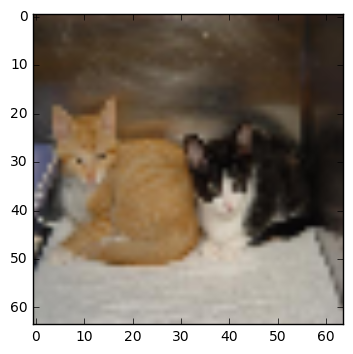

In [4]:
plt.imshow(x_train[1])
plt.show()

In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [9]:
# def build_model():
#     model = Sequential()
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#     model.add(Dropout(0.25)) #在训练过程中每次更新参数时按一定概率（rate）随机断开输入神经元，Dropout层用于防止过拟合

#     model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#     model.add(Dropout(0.25))

#     #把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))
    
#     model.compile(optimizer=RMSprop(decay=1e-6), loss='binary_crossentropy', metrics=['accuracy']) #二分类
    
#     return model

In [10]:
def VGG_16():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())

    #top layer of the VGG net
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))

    model.compile(optimizer=RMSprop(decay=1e-6), loss='binary_crossentropy', metrics=['accuracy']) #二分类
    
    return model

In [11]:
# model = build_model()
model = VGG_16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 256)       295168    
__________

In [12]:
#使用cross validation评估模型
folds = 4
nb_samples = len(x_train) // folds
nb_epochs = 2
cv_scores = []
for i in range(folds):
#     test_model = build_model()
    test_model = VGG_16()
    #验证集
    val_data = x_train[i*nb_samples : (i+1)*nb_samples]
    val_targets = y_train[i*nb_samples : (i+1)*nb_samples]
    #训练集
    X_train = np.vstack((x_train[ : i*nb_samples], x_train[(i+1)*nb_samples : ]))
    Y_train = np.hstack((y_train[ : i*nb_samples], y_train[(i+1)*nb_samples : ]))
    test_model.fit(X_train, Y_train, epochs=nb_epochs, verbose=0, shuffle=True)
    loss, acc = test_model.evaluate(val_data, val_targets, verbose=0)
    cv_scores.append(acc)
    print('第 %d 折, loss:%f  acc:%f'%(i+1, loss, acc))
    
print(np.mean(cv_scores),np.std(cv_scores))

KeyboardInterrupt: 

我们将使用scikit-learn的k-fold交叉评估模型验证。这是一个重采样进行模型性能评估的技术。
它通过把数据分成k个部分,训练模型在所有k部分中分出一个作为测试集对模型的性能进行评估。
这个过程重复 k 次的平均分数作为所有构造模型稳健的性能评估。它是分层的,这意味着它将关注输出值并试图平衡K份数据中每个类别的实例数量。
在 scikit-learn 中使用 Keras 的模型,我们必须使用 KerasClassifier 进行包装。
这个类起到创建并返回我们的神经网络模型的作用。它需要传入调用 fit()所需要的参数,比如迭代次数和批处理大小。

In [45]:
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
start = time.time()
estimator = KerasClassifier(build_fn=build_model, epochs=5, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0) # Stratified K-Folds cross-validator(分层交叉验证框架)
results = cross_val_score(estimator, x_train, y_train, scoring='accuracy', cv=kfold) # Evaluate a score by cross-validation
end = time.time()
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) # 预测准确率和平均标准偏差
print('用时：',end-start,'秒')

Epoch 1/5
2666/2666 [==============================] - 32s 12ms/step - loss: 0.6943 - acc: 0.4854
Epoch 2/5
2666/2666 [==============================] - 30s 11ms/step - loss: 0.6934 - acc: 0.4827
Epoch 3/5
2666/2666 [==============================] - 29s 11ms/step - loss: 0.6936 - acc: 0.4854
Epoch 4/5
2666/2666 [==============================] - 30s 11ms/step - loss: 0.6934 - acc: 0.4831
Epoch 5/5
1334/1334 [==============================] - 5s 3ms/step
Epoch 1/5
2666/2666 [==============================] - 32s 12ms/step - loss: 0.6939 - acc: 0.4977
Epoch 2/5
2666/2666 [==============================] - 30s 11ms/step - loss: 0.6933 - acc: 0.4962
Epoch 3/5
2666/2666 [==============================] - 31s 12ms/step - loss: 0.6934 - acc: 0.4801
Epoch 4/5
2666/2666 [==============================] - 30s 11ms/step - loss: 0.6935 - acc: 0.4850
Epoch 5/5
1334/1334 [==============================] - 4s 3ms/step
Epoch 1/5
2668/2668 [==============================] - 34s 13ms/step - loss: 0.694

In [12]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
cvscores = []
for train_index, test_index in kfold.split(x_train, y_train):
    print("index:",train_index.shape,test_index.shape)
    model = build_model()
    # Fit the model
    model.fit(x_train[train_index], y_train[train_index], epochs=2, verbose=0)
    # evaluate the model
    scores = model.evaluate(x_train[test_index], y_train[test_index], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

index: (3000,) (1000,)
acc: 50.00%
index: (3000,) (1000,)
acc: 50.00%
index: (3000,) (1000,)
acc: 50.00%
index: (3000,) (1000,)
acc: 50.00%
50.00% (+/- 0.00%)


In [14]:
hist = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), shuffle=True)

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
3968/4000 [============================>.] - ETA: 8s - loss: 7.9632 - acc: 0.5005 

KeyboardInterrupt: 

In [14]:
loss, acc = model.evaluate(x_test, y_test)
#模型的测试误差指标
print(model.metrics_names)
print('loss: ',loss)
print('accuracy: ',acc)

1000/1000 [==============================] - 4s 4ms/step
['loss', 'acc']
loss:  0.693225323677
accuracy:  0.5


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


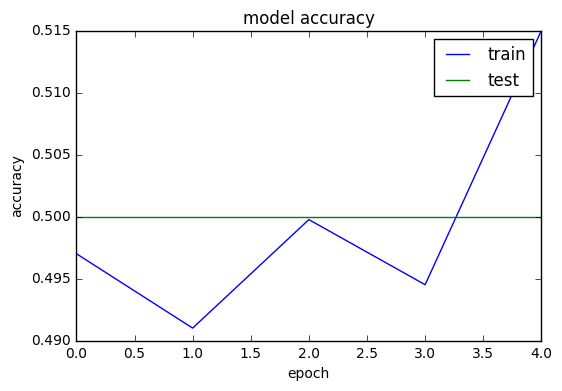

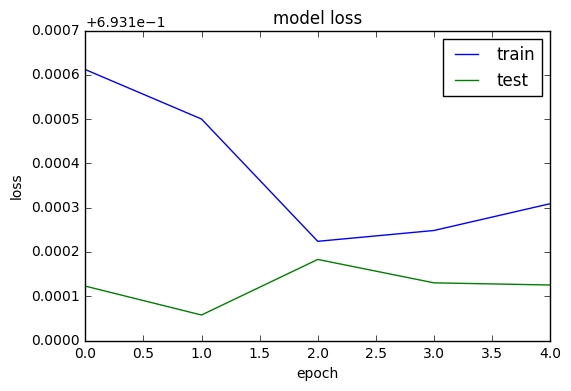

In [15]:
print(hist.history.keys())
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

plt.figure()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

1/1 [==============================] - 0s 282ms/step
[[0]]
1/1 [==============================] - 0s 6ms/step
[[0]]
1/1 [==============================] - 0s 7ms/step
[[0]]
1/1 [==============================] - 0s 10ms/step
[[0]]
1/1 [==============================] - 0s 5ms/step
[[0]]
1/1 [==============================] - 0s 4ms/step
[[0]]
1/1 [==============================] - 0s 4ms/step
[[0]]
1/1 [==============================] - 0s 6ms/step
[[0]]
1/1 [==============================] - 0s 5ms/step
[[0]]
1/1 [==============================] - 0s 4ms/step
[[0]]
1/1 [==============================] - 0s 5ms/step
[[0]]
1/1 [==============================] - 0s 7ms/step
[[0]]


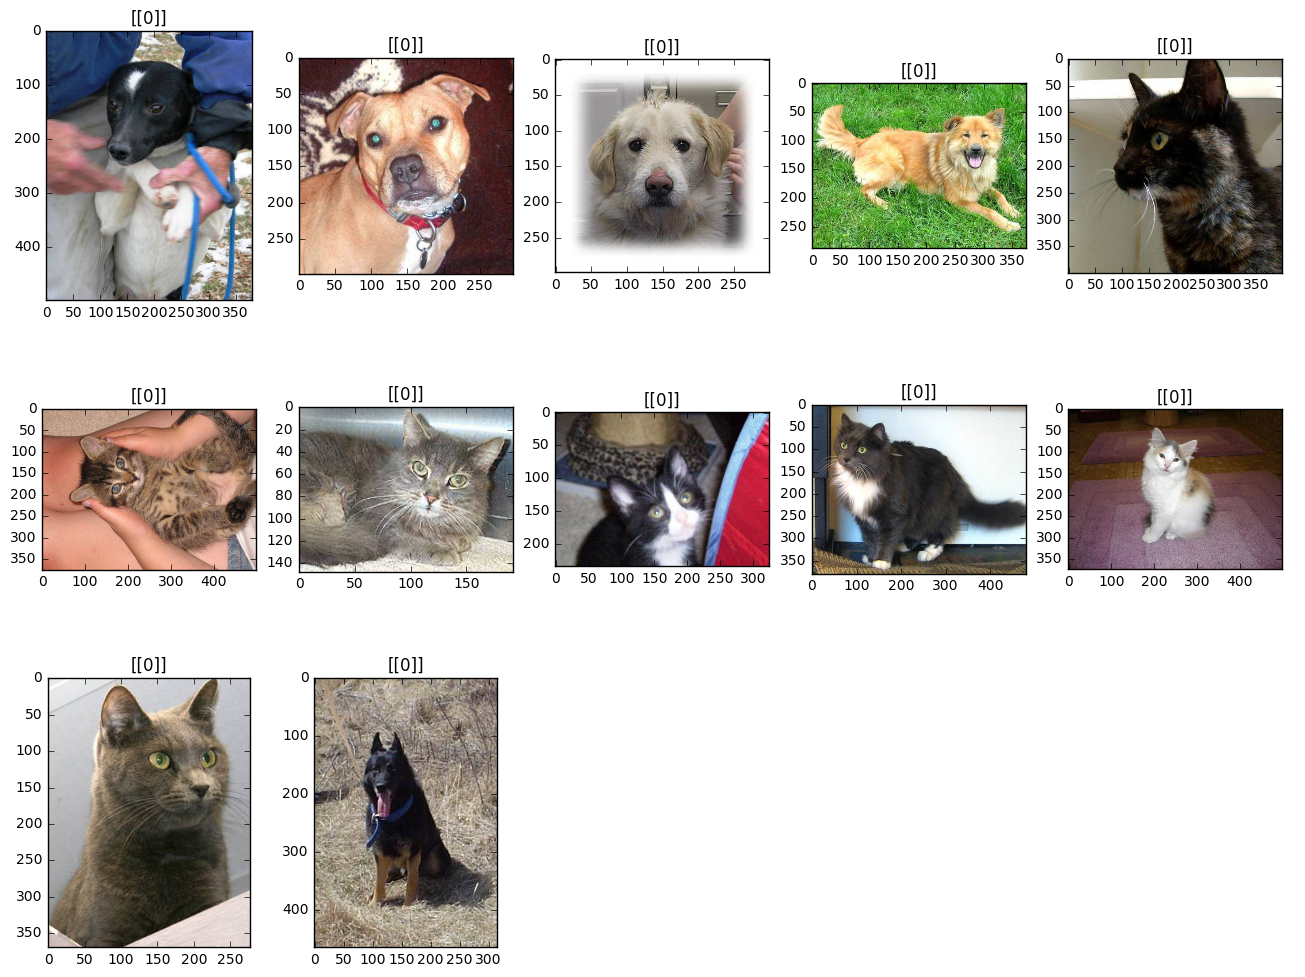

In [16]:
from skimage.transform import resize

fig=plt.figure(figsize=(16, 16))
for i in range(1, 13):
    my_image =  'PetImages/images/test/{}.jpg'.format(i)
    my_image = plt.imread(my_image)
    ax = fig.add_subplot(4, 5, i)
    plt.imshow(my_image)
    num_px = 64

    my_image = resize(my_image, (num_px, num_px, 3))
    my_image = np.expand_dims(my_image, axis=0)
#     my_image = my_image.reshape(1, num_px, num_px, 3) #1张32*32*3的图片

#     res = model.predict(my_image) #预测的是实数值（预测概率）
#     print(res, np.argmax(res))

    res = model.predict_classes(my_image) #预测的是类别，打印出来的值就是类别号
    print(res)

    #由于猫类对应的标签为1，大于0.5则认为是1
    ax.title.set_text(str(res)+'')
plt.show()

In [38]:
import random
from sklearn.model_selection import train_test_split
dataset = np.random.uniform(size=(100,2))
labels = [random.randint(0,1) for _ in range(100)]
print(dataset.shape,type(dataset))
print(labels)
X_train, X_test, y_train, y_test = train_test_split(dataset,labels,test_size=0.25,random_state=46)
print(X_train.shape,X_test.shape)
print(np.shape(y_train),np.shape(y_test))
print(y_test)

(100, 2) <class 'numpy.ndarray'>
[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
(75, 2) (25, 2)
(75,) (25,)
[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


In [54]:
x = np.array([[1,2,3],[3,5,6]])
y = np.expand_dims(x, axis=0)
print(x.shape, y.shape)

(2, 3) (1, 2, 3)


In [29]:
import numpy
a = np.zeros([1])
print(a)
a = np.insert(a,0,[2],axis=0)
print(a,a.shape)
a = np.delete(a,-1,axis=0)
print(a,a.shape)

[ 0.]
[ 2.  0.] (2,)
[ 2.] (1,)


In [5]:
import random
import numpy as np

a = np.array([[1],[2],[3],[4],[5]])
print(a, a.shape)

print(a.flatten())

b = a.reshape((5,))
print(b, b.shape)

x = np.array([[1,2,3],[3,4,5]])
print(x,x.shape)
y = x.reshape((1,)+x.shape)
print(y,y.shape)

[[1]
 [2]
 [3]
 [4]
 [5]] (5, 1)
[1 2 3 4 5]
[1 2 3 4 5] (5,)
[[1 2 3]
 [3 4 5]] (2, 3)
[[[1 2 3]
  [3 4 5]]] (1, 2, 3)
